In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 4
EPOCHS = 10
data_dir = "/home/iai/Desktop/Jeewon/Seminar/20230112_MVtecAD/data/dataset_auto"

cuda


In [188]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
print(train_dataset.classes)
print("size of train dataset : ", len(train_dataset))
print(train_dataset[0][0].shape)

test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 2)
print(test_dataset.classes)
print("size of test dataset : ", len(test_dataset))

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
size of train dataset :  3629
torch.Size([3, 224, 224])
['bottle_broken_large', 'bottle_broken_small', 'bottle_contamination', 'bottle_good', 'cable_bent_wire', 'cable_combined', 'cable_cut_inner_insulation', 'cable_cut_outer_insulation', 'cable_good', 'cable_missing_cable', 'cable_missing_wire', 'cable_poke_insulation', 'cable_swap', 'capsule_crack', 'capsule_faulty_imprint', 'capsule_good', 'capsule_poke', 'capsule_scratch', 'capsule_squeeze', 'carpet_color', 'carpet_cut', 'carpet_good', 'carpet_hole', 'carpet_metal_contamination', 'carpet_thread', 'grid_bent', 'grid_broken', 'grid_glue', 'grid_good', 'grid_metal_contamination', 'grid_thread', 'hazelnut_crack', 'hazelnut_cut', 'hazelnut_good', 'hazelnut_hole', 'hazelnut_print', 'leather_color', 'leather_cut', 'leather_fold', 'leather_glue', 'leather_good', 'leather_poke', 'metal_n

In [142]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

tensor(-0.9216) tensor(1.)
tensor([1, 0, 9, 7])
torch.Size([4, 3, 224, 224])
torch.float32


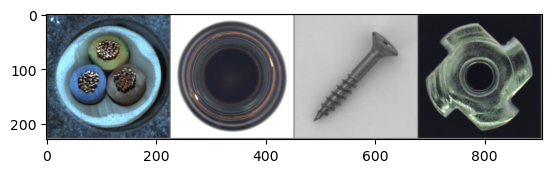

torch.Size([4, 3, 224, 224])


In [215]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

print(images.shape)
print(images.dtype)

imshow(torchvision.utils.make_grid(images))
print(images.shape)

tensor(-0.7647) tensor(1.)


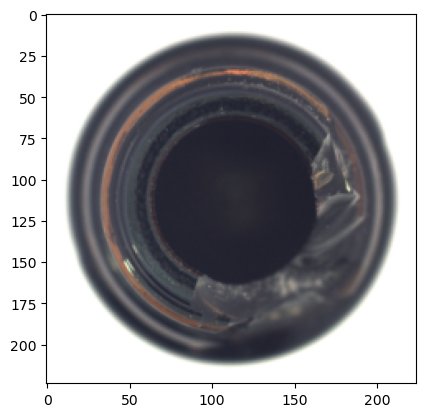

torch.Size([1, 3, 224, 224])


In [144]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [145]:
# CNN Autoencoder

class CNN_Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 3, 224, 224
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 4, stride = 2, padding = 1), # N, 16, 112, 112
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride = 2, padding = 1), # N, 32, 56, 56
        nn.ReLU(),
        nn.Conv2d(32, 64, 4, stride = 2, padding = 1), # N, 64, 28, 28
        nn.ReLU(),
        nn.Conv2d(64, 128, 4, stride = 2, padding = 1), # N, 128, 14, 14
        nn.ReLU(),
        nn.Conv2d(128, 256, 14) # N, 256, 1, 1
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 14),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, 4, stride = 2, padding = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [146]:
model = CNN_Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [147]:
output_train = []
train_loss = []

for epoch in range(EPOCHS):
  for (img, _) in train_loader:
    # img = img.reshape(-1, 224*224*3)
    img = img.to(device)
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  output_train.append((epoch, img, recon))

Epoch:1, Loss:0.4530
Epoch:2, Loss:0.5073
Epoch:3, Loss:0.2695
Epoch:4, Loss:0.5318
Epoch:5, Loss:0.4407
Epoch:6, Loss:0.2299
Epoch:7, Loss:0.2197
Epoch:8, Loss:0.2043
Epoch:9, Loss:0.1375
Epoch:10, Loss:0.2052


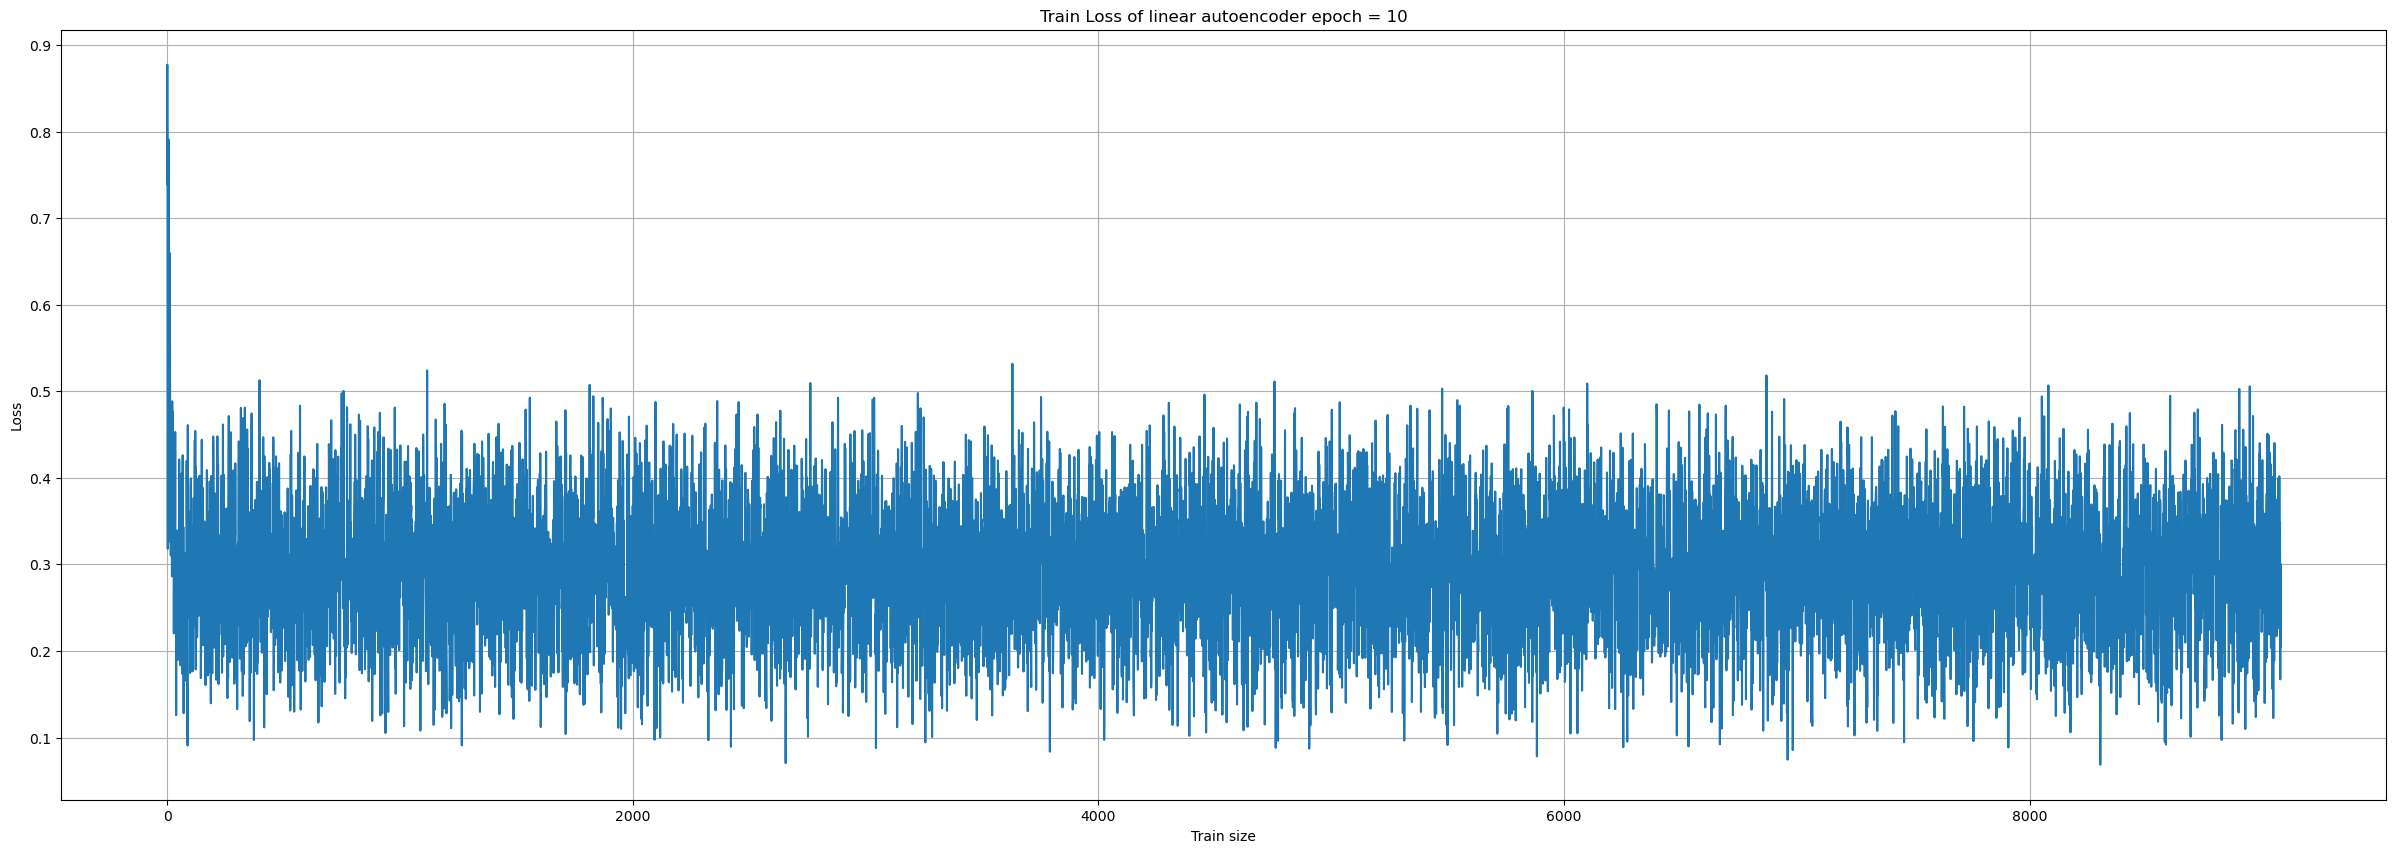

In [174]:
plt.figure(figsize=(30,10))
plt.plot(train_loss)
plt.grid()
plt.xlabel('Train size')
plt.ylabel('Loss')
plt.title('Train Loss of linear autoencoder epoch = 10')
plt.legend
plt.show()

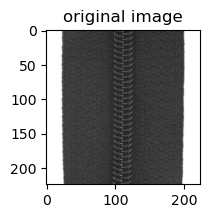

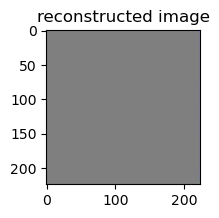

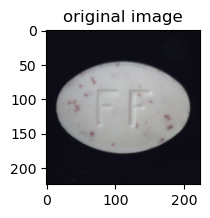

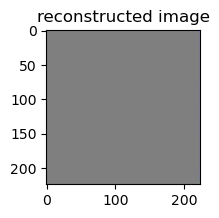

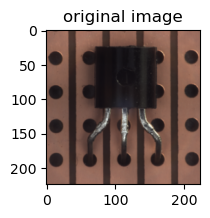

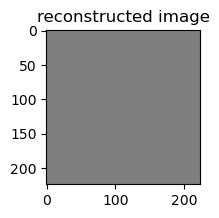

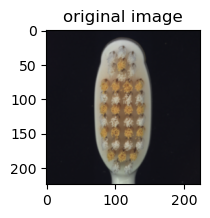

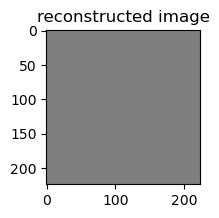

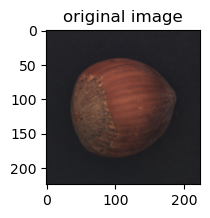

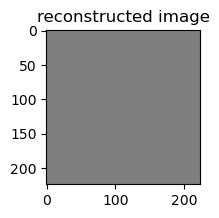

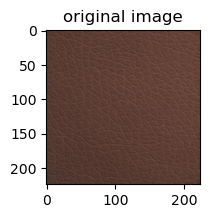

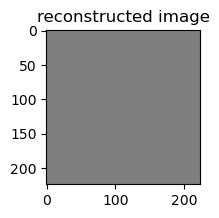

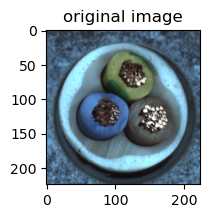

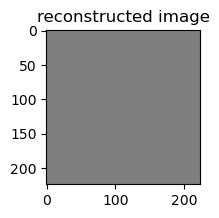

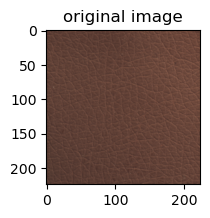

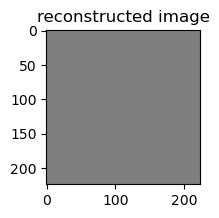

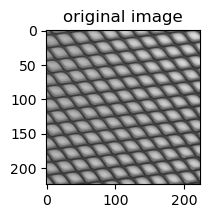

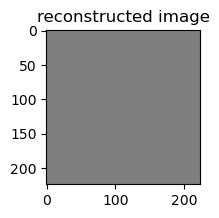

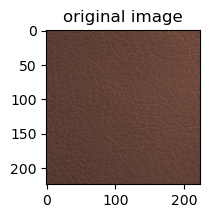

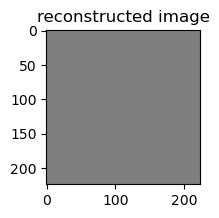

In [149]:
for k in range(0, EPOCHS):
    plt.figure(figsize=(10, 2))
    plt.title("original image")
    imgs = output_train[k][1].cpu()
    recon = output_train[k][2].detach().cpu()
    for i, item in enumerate(imgs):
        if i >= 9: break
        item = item.reshape(3,224,224) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        # plt.imshow(item[0])
        imshow(item)
    plt.figure(figsize=(10, 2))  
    plt.title("reconstructed image")      
    for i, item in enumerate(recon):
        if i >= 9: break
        item = item.reshape(3, 224,224) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        # plt.imshow(item[0])
        imshow(item)

In [150]:
test_loss = []
output_test = []

with torch.no_grad():
  for (img, _) in test_loader:
    # img = img.reshape(-1, 224*224*3)
    img = img.to(device)
    recon = model(img)
    loss = criterion(recon, img)
    test_loss.append(loss.item())
    
  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  output_test.append((epoch, img, recon))

Epoch:10, Loss:0.4738


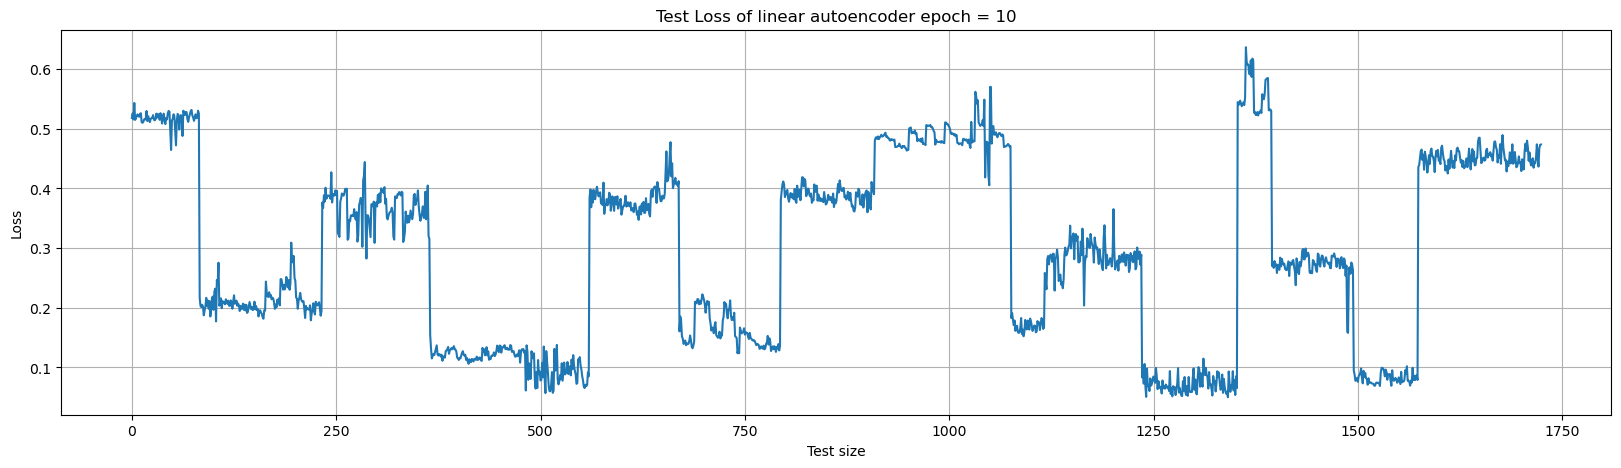

In [176]:
plt.figure(figsize=(20,5))
plt.plot(test_loss)
plt.grid()
plt.xlabel('Test size')
plt.ylabel('Loss')
plt.title('Test Loss of linear autoencoder epoch = 10')
plt.legend
plt.show()

In [253]:
import pandas as pd

label_list = []

df_trainloss = pd.DataFrame({'train_loss':train_loss,'label':'good'})

dict = test_dataset.class_to_idx
print(dict)

dataiter = iter(test_loader)
for i in range(len(test_loader)):
    _, labels = next(dataiter)
    label_list.append(labels.numpy())

print(len(label_list))
print(len(test_loss))
df_testloss = pd.DataFrame({'test_loss':test_loss,'label':label_list})

{'bottle_broken_large': 0, 'bottle_broken_small': 1, 'bottle_contamination': 2, 'bottle_good': 3, 'cable_bent_wire': 4, 'cable_combined': 5, 'cable_cut_inner_insulation': 6, 'cable_cut_outer_insulation': 7, 'cable_good': 8, 'cable_missing_cable': 9, 'cable_missing_wire': 10, 'cable_poke_insulation': 11, 'cable_swap': 12, 'capsule_crack': 13, 'capsule_faulty_imprint': 14, 'capsule_good': 15, 'capsule_poke': 16, 'capsule_scratch': 17, 'capsule_squeeze': 18, 'carpet_color': 19, 'carpet_cut': 20, 'carpet_good': 21, 'carpet_hole': 22, 'carpet_metal_contamination': 23, 'carpet_thread': 24, 'grid_bent': 25, 'grid_broken': 26, 'grid_glue': 27, 'grid_good': 28, 'grid_metal_contamination': 29, 'grid_thread': 30, 'hazelnut_crack': 31, 'hazelnut_cut': 32, 'hazelnut_good': 33, 'hazelnut_hole': 34, 'hazelnut_print': 35, 'leather_color': 36, 'leather_cut': 37, 'leather_fold': 38, 'leather_glue': 39, 'leather_good': 40, 'leather_poke': 41, 'metal_nut_bent': 42, 'metal_nut_color': 43, 'metal_nut_flip':

In [201]:
print("Length of loss : {}".format(len(train_loss)))
print("Num of loss over 0.5 : {}".format(df_trainloss[(df_trainloss['train_loss']>0.5)].count()))
print("Num of loss over 0.4 : {}".format(df_trainloss[(df_trainloss['train_loss']>0.4)].count()))
print("Num of loss over 0.3 : {}".format(df_trainloss[(df_trainloss['train_loss']>0.3)].count()))
print("Num of loss over average : {}".format(df_trainloss[(df_trainloss['train_loss'] > df_trainloss["train_loss"].mean())].count()))

Length of loss : 9080
Num of loss over 0.5 : train_loss    23
label         23
dtype: int64
Num of loss over 0.4 : train_loss    779
label         779
dtype: int64
Num of loss over 0.3 : train_loss    4202
label         4202
dtype: int64
Num of loss over average : train_loss    4527
label         4527
dtype: int64


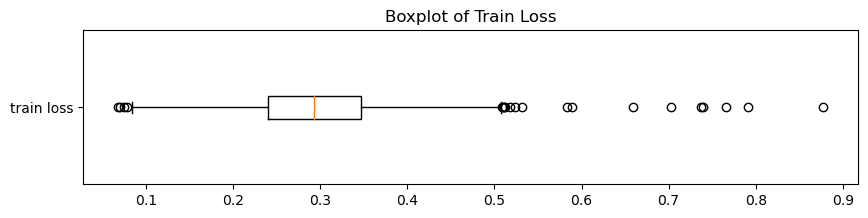

        train_loss
count  9080.000000
mean      0.293491
std       0.078012
min       0.068583
25%       0.239897
50%       0.293205
75%       0.347079
max       0.877141
Frequency of loss less than 3QR : train_loss    6810
label         6810
dtype: int64


In [206]:
plt.figure(figsize=(10,2))
plt.boxplot(df_trainloss['train_loss'], vert = 0)
plt.title("Boxplot of Train Loss")
plt.yticks([1],["train loss"])
plt.show()

print(df_trainloss.describe())
trainloss_75 = np.percentile(df_trainloss['train_loss'], 75)
trainloss_25 = np.percentile(df_trainloss['train_loss'], 25)

print("Frequency of loss less than 3QR : {}".format(df_trainloss[(df_trainloss['train_loss'] > trainloss_25)].count()))

In [207]:
print("Length of test : {}".format(len(test_loss)))
print(df_testloss.describe())

Length of test : 1725
         test_loss
count  1725.000000
mean      0.294580
std       0.152643
min       0.050125
25%       0.143927
50%       0.288471
75%       0.435130
max       0.636817


In [209]:
threshold = np.percentile(df_trainloss['train_loss'], 75)

In [210]:
tmp = df_testloss[(df_testloss['test_loss']>threshold)].count()
print("Num of anomalies less than 3QR : {}".format(tmp))
print(tmp / len(test_dataset))

df_testloss[(df_testloss['test_loss'] > threshold)]


Num of anomalies less than 3QR : test_loss    777
dtype: int64
test_loss    0.450435
dtype: float64


,test_loss
0,0.518222
1,0.525924
2,0.515741
3,0.543417
4,0.514963
...,...
1720,0.450223
1721,0.436756
1722,0.467340
1723,0.473201


In [214]:
test_dataset.class_to_idx

{'bottle_broken_large': 0,
 'bottle_broken_small': 1,
 'bottle_contamination': 2,
 'bottle_good': 3,
 'cable_bent_wire': 4,
 'cable_combined': 5,
 'cable_cut_inner_insulation': 6,
 'cable_cut_outer_insulation': 7,
 'cable_good': 8,
 'cable_missing_cable': 9,
 'cable_missing_wire': 10,
 'cable_poke_insulation': 11,
 'cable_swap': 12,
 'capsule_crack': 13,
 'capsule_faulty_imprint': 14,
 'capsule_good': 15,
 'capsule_poke': 16,
 'capsule_scratch': 17,
 'capsule_squeeze': 18,
 'carpet_color': 19,
 'carpet_cut': 20,
 'carpet_good': 21,
 'carpet_hole': 22,
 'carpet_metal_contamination': 23,
 'carpet_thread': 24,
 'grid_bent': 25,
 'grid_broken': 26,
 'grid_glue': 27,
 'grid_good': 28,
 'grid_metal_contamination': 29,
 'grid_thread': 30,
 'hazelnut_crack': 31,
 'hazelnut_cut': 32,
 'hazelnut_good': 33,
 'hazelnut_hole': 34,
 'hazelnut_print': 35,
 'leather_color': 36,
 'leather_cut': 37,
 'leather_fold': 38,
 'leather_glue': 39,
 'leather_good': 40,
 'leather_poke': 41,
 'metal_nut_bent': 42